In [1]:
''' 
@karlpy 
karl@elindicador.ai
Date: 2023-04-10
'''

' \n@karlpy \nDate: 2023-04-10\n'

In [2]:
import polars as pl
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 1: Merge & BigQuery

- Primero hice merge de los [datos](https://drive.google.com/drive/folders/12EbE0PEEnCjUVjhzMDNa1W7M9tR4ZzwW?usp=share_link)
> awk -F ';' 'FNR==1 && NR!=1{next} {print}' *.csv | sed '/^$/d' > merged.csv
- Luego subí al CSV a BigQuery

La tabla de bigquery queda así
```bash
Campo Descripción Tipo de Dato
serialtarjeta: Serial de la Tarjeta que identifica al pasajero hash
idsam: Identificacion del bus de transporte público hash
fechahoraevento: timestamp del inicio del viaje timestamp
producto: Tipo de Producto string
montoevento: Monto del evento descontado de la tarjeta entero
consecutivoevento: Consecutivo del evento entero
identidad: Identidad entero
tipoevento: Tipo de Evento entero
latitude: Latitud geografica punto flotante
longitude: Longitud geografica punto flotante
idrutaestacion: Linea o ruta utilizada string
tipotransporte: tipo de transporte entero
```

## Reducción de dimensionalidad 
Primero intenté aplicar al algoritmo kmeans directamente a los datos en BigQuery, pero no terminó de procesar en más que 24h. Por lo cual hice una reducción de dimensionalidad con este query:

```sql
SELECT 
  serialtarjeta AS serialtarjeta,
  COUNT(*) AS count,
  AVG(CAST(montoevento AS NUMERIC)) AS avg_montoevento,
  STDDEV(CAST(montoevento AS NUMERIC)) AS stddev_montoevento,
  APPROX_QUANTILES(CAST(montoevento AS NUMERIC), 100)[OFFSET(50)] AS median_montoevento,
  AVG(CAST(consecutivoevento AS NUMERIC)) AS avg_consecutivoevento,
  STDDEV(CAST(consecutivoevento AS NUMERIC)) AS stddev_consecutivoevento,
  APPROX_QUANTILES(CAST(consecutivoevento AS NUMERIC), 100)[OFFSET(50)] AS median_consecutivoevento,
  AVG(CAST(identidad AS NUMERIC)) AS avg_identidad,
  STDDEV(CAST(identidad AS NUMERIC)) AS stddev_identidad,
  APPROX_QUANTILES(CAST(identidad AS NUMERIC), 100)[OFFSET(50)] AS median_identidad,
  AVG(CAST(tipoevento AS NUMERIC)) AS avg_tipoevento,
  STDDEV(CAST(tipoevento AS NUMERIC)) AS stddev_tipoevento,
  APPROX_QUANTILES(CAST(tipoevento AS NUMERIC), 100)[OFFSET(50)] AS median_tipoevento,
  AVG(latitude) AS avg_latitude,
  STDDEV(latitude) AS stddev_latitude,
  APPROX_QUANTILES(latitude, 100)[OFFSET(50)] AS median_latitude,
  AVG(longitude) AS avg_longitude,
  STDDEV(longitude) AS stddev_longitude,
  APPROX_QUANTILES(longitude, 100)[OFFSET(50)] AS median_longitude,
  AVG(CAST(tipotransporte AS NUMERIC)) AS avg_tipotransporte,
  STDDEV(CAST(tipotransporte AS NUMERIC)) AS stddev_tipotransporte,
  APPROX_QUANTILES(CAST(tipotransporte AS NUMERIC), 100)[OFFSET(50)] AS median_tipotransporte
FROM 
  `billetaje_electronico.billetaje_electronico`
GROUP BY 
  serialtarjeta
```


In [3]:
# leemos al CSV resultante del query de SQL
# link: https://drive.google.com/file/d/1UHAqyH5znO9JSOCn72Wgf8j7iIYWN9i8/view?usp=share_link

df = pd.read_csv('kmeans_data.csv')
df.head()

,serialtarjeta,count,avg_montoevento,stddev_montoevento,median_montoevento,avg_consecutivoevento,stddev_consecutivoevento,median_consecutivoevento,avg_identidad,stddev_identidad,...,median_tipoevento,avg_latitude,stddev_latitude,median_latitude,avg_longitude,stddev_longitude,median_longitude,avg_tipotransporte,stddev_tipotransporte,median_tipotransporte
0,13105046b4d5c6c71a83ab77206b0a0b,100,2662.000000,949.420068,3128,69.900000,38.887172,70,2.510000,0.502418,...,4,-25.327551,0.052038,-25.34457,-57.522094,0.076712,-57.50643,2.220000,0.980414,3
1,5c6a3890b1452165e63416b5f455d92a,79,2654.430380,746.237995,2700,173.316456,31.205499,173,2.911392,0.285992,...,4,-24.986290,2.847286,-25.31474,-56.877138,6.481260,-57.60941,1.784810,0.982812,1
2,153c437c806a2418a1f78d666266ba2b,49,2730.612245,698.571185,2400,46.959184,18.359783,45,2.591837,0.496587,...,4,-24.732421,3.607212,-25.23178,-56.392946,8.224074,-57.54937,2.142857,1.000000,3
3,a87b1c27cb7cb08cdf411451ca1faee8,204,2708.823529,814.233350,2900,321.799020,81.176047,321,2.588235,0.493364,...,4,-25.329579,0.048353,-25.34273,-57.536748,0.040400,-57.52056,2.245098,0.971883,3
4,ebb70421e1cf82778d58d90d2111a18e,2,1150.000000,1626.345597,0,16.500000,0.707107,16,3.000000,0.000000,...,4,-25.191900,0.000000,-25.19190,-57.505140,0.000000,-57.50514,1.000000,0.000000,1


# Kmeans

In [4]:
df.columns

Index(['serialtarjeta', 'count', 'avg_montoevento', 'stddev_montoevento',
       'median_montoevento', 'avg_consecutivoevento',
       'stddev_consecutivoevento', 'median_consecutivoevento', 'avg_identidad',
       'stddev_identidad', 'median_identidad', 'avg_tipoevento',
       'stddev_tipoevento', 'median_tipoevento', 'avg_latitude',
       'stddev_latitude', 'median_latitude', 'avg_longitude',
       'stddev_longitude', 'median_longitude', 'avg_tipotransporte',
       'stddev_tipotransporte', 'median_tipotransporte'],
      dtype='object')

## Buscamos a las columnas ideales para el algoritmo Kmeans

Best columns for clustering: ['count', 'avg_consecutivoevento', 'stddev_consecutivoevento', 'median_consecutivoevento', 'stddev_tipoevento', 'stddev_latitude', 'stddev_longitude']


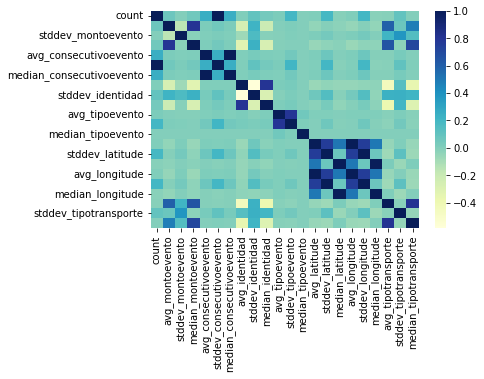

In [5]:
# Separate out the id column
id_col = df['serialtarjeta']
df = df.drop('serialtarjeta', axis=1)
# drop na values
df = df.dropna()

# Find the best columns for clustering using correlation
corr_matrix = df.corr()
corr_with_id = corr_matrix.iloc[0]
best_cols = list(corr_with_id[corr_with_id.abs() > 0.1].index)
print('Best columns for clustering:', best_cols)

# plot the correlation matrix using a heatmap
sns.heatmap(corr_matrix, cmap="YlGnBu")

# display the plot
plt.show()

## Buscamos al numero óptimo de clusteres 

c:\ProgramData\mambaforge\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\

Optimum Clusters:  4


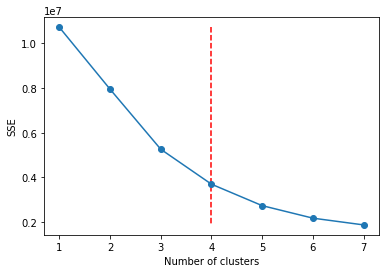

In [6]:
from kneed import KneeLocator

# Normalize the data
scaler = StandardScaler()
df_norm = scaler.fit_transform(df[best_cols])

# Determine the optimal number of clusters using the KneeLocator
distortions = []
n_columns = len(best_cols) + 1
for k in range(1, n_columns):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_norm)
    distortions.append(kmeans.inertia_)
    
kl = KneeLocator(range(1, n_columns), distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

# Plot the SSE against number of clusters
plt.plot(range(1, n_columns), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.vlines(c, ymin=distortions[0], ymax=distortions[-1], colors='r', linestyles='dashed')
plt.show()


## Aplicamos al algoritmo de Kmeans

In [7]:
# Fit the KMeans model using the optimal number of clusters
kmeans = KMeans(n_clusters=n_columns)
kmeans.fit(df_norm)

# Add the cluster labels and id column back to the dataframe
df['cluster'] = kmeans.labels_
df['serialtarjeta'] = id_col

# Print the cluster sizes
print(df['cluster'].value_counts())

c:\ProgramData\mambaforge\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3    658949
0    363983
2    171447
6    128437
4    115090
5     64523
7     27518
1         1
Name: cluster, dtype: int64


## Hacemos una pre-visualización

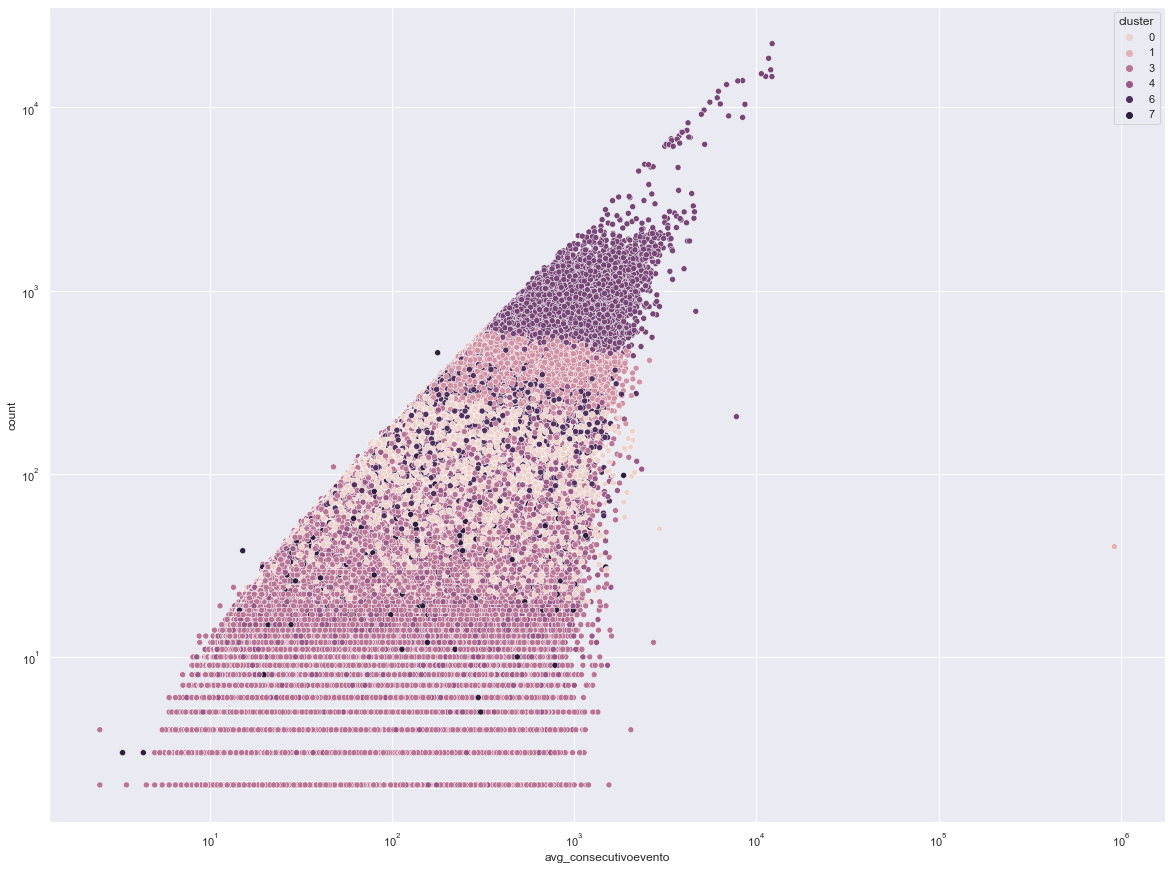

In [8]:
import seaborn as sns

# Create a 20 by 15 scatterplot of the data colored by cluster
sns.set(rc={'figure.figsize':(20,15)})
sns.scatterplot(data=df, x='avg_consecutivoevento', y='count', hue='cluster')
# Set axis to log scale
plt.yscale('log')
plt.xscale('log')
plt.show()

In [9]:
# Data is too big for TSNE

# from sklearn.manifold import TSNE

# # Fit t-SNE to the normalized data
# tsne = TSNE(learning_rate=200, random_state=42)
# df_tsne = tsne.fit_transform(df_norm)

# # Add the t-SNE coordinates to the dataframe
# df['tsne_x'] = df_tsne[:,0]
# df['tsne_y'] = df_tsne[:,1]

# # Create a scatterplot of the data colored by cluster
# sns.scatterplot(data=df, x='tsne_x', y='tsne_y', hue='cluster')


## Visualizamos usando UMAP (una alternativa mas rápida a TSNE)

In [10]:
import umap

# Fit UMAP to the normalized data
umap_model = umap.UMAP(metric='euclidean', random_state=42)
umap_embeddings = umap_model.fit_transform(df_norm)

# Add the UMAP coordinates to the dataframe
df['umap_x'] = umap_embeddings[:,0]
df['umap_y'] = umap_embeddings[:,1]

# Create a scatterplot of the data colored by cluster
sns.scatterplot(data=df, x='umap_x', y='umap_y', hue='cluster')


In [ ]:
import plotly.express as px

# Create a scatterplot of the data colored by cluster
fig = px.scatter(df, x='umap_x', y='umap_y', color='cluster')

# Set the size of the figure
fig.update_layout(width=1000, height=750)

# Show the plot
fig.show()
fig.write_html("kmeans_tsne.html")
